# Ford GoBike dataset analysis
## by Andrés Ingelmo Poveda

## Preliminary Wrangling

This dataset includes informationabout individual rides made in a bike-sharing system covering the greater San Francisco area during the month of February 2019. Questions like "how long does the average trip take" or "how does suscription status impacts in the results" will be answered. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import requests

%matplotlib inline

In [2]:
url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
file = "fordgobikedata.csv"

# Function to get the file from the cloud
def get_file(url, file):
    # Get the file from the cloud
    content = requests.get(url).text
    # Write the file into "fordgobikedata.csv"
    with open(file, "w", encoding="utf-8") as f:
        f.write(content)
        
##Run only the first time to get the file from the cloud!
#get_file(url, file) ##<-- Remove "#" to run 

# Load the csv file into a pandas dataframe
ford = pd.read_csv(file)

### What is the structure of your dataset?

In [3]:
ford.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [4]:
ford.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

### What is/are the feature(s) of interest in your dataset?

The main features of interest in the data are:
- `duration_sec`: the main feature of exploration.
- `start_time`and `end_time`: it can provide valuable data regarding the busiest hours.
- `start_station_id` and `end_station_id`: it can provide data regarding the busiest stations.
- `bike_id`: is there any bike that is more used than others?
- `user_type`: it can provide valuable data regarding different behaviours from customers and suscribers.
- `member_birth_year`: are young people using bikesharing more?
- `member_gender`: is gender determinant while bikesharing? is there a different behaviour?

The data needs some cleaning to convert the variables into its correct type. But first, a copy of the original dataframe will be done.

In [5]:
#Create a copy of the original
ford_clean = ford.copy()

#Drop missing values 
ford_clean.dropna(inplace=True)

#Convert to date/time
ford_clean["start_time"] = pd.to_datetime(ford_clean["start_time"])
ford_clean["end_time"] = pd.to_datetime(ford_clean["end_time"])

#Divide date/time variables in order to plot it correctly
ford_clean["start_time_hour"] = pd.DatetimeIndex(ford_clean["start_time"]).hour.astype("category")
ford_clean["end_time_hour"] = pd.DatetimeIndex(ford_clean["end_time"]).hour.astype("category")

#Get day of the week for the start an end time.
ford_clean["start_time_weekday"] = ford_clean["start_time"].dt.dayofweek
ford_clean["end_time_weekday"] = ford_clean["end_time"].dt.dayofweek

#Convert day of the week to string
week_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

ford_clean["start_time_weekday"].replace(week_dict, inplace=True)
ford_clean["end_time_weekday"].replace(week_dict, inplace=True)

#Convert to strings as not calculations are required for the data below
to_clean = ["start_station_id", "end_station_id", "bike_id"]

for i in to_clean:
    ford_clean[i] = ford_clean[i].fillna(0).astype(int).astype(str) 

    
#Convert to categorical values
ford_clean["member_gender"] = ford_clean["member_gender"].astype("category")
ford_clean["user_type"] = ford_clean["user_type"].astype("category")
ford_clean["member_birth_year"] = ford_clean["member_birth_year"].astype(int).astype("category")
ford_clean["bike_share_for_all_trip"] = ford_clean["bike_share_for_all_trip"].astype("category")
ford_clean["start_time_weekday"] = ford_clean["start_time_weekday"].astype("category")
ford_clean["end_time_weekday"] = ford_clean["end_time_weekday"].astype("category")
    
#Drop Columns not necessary for the analysis
ford_clean.drop(labels=["start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude"], axis=1, inplace=True);

In [6]:
ford_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  object        
 4   start_station_name       174952 non-null  object        
 5   end_station_id           174952 non-null  object        
 6   end_station_name         174952 non-null  object        
 7   bike_id                  174952 non-null  object        
 8   user_type                174952 non-null  category      
 9   member_birth_year        174952 non-null  category      
 10  member_gender            174952 non-null  category      
 11  bike_share_for_all_trip  174952 non-null  category      
 12  start_time_hour 

In [7]:
ford_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_time_hour,end_time_hour,start_time_weekday,end_time_weekday
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),13,Commercial St at Montgomery St,4902,Customer,1984,Male,No,17,8,Thursday,Friday
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,3,Powell St BART Station (Market St at 4th St),5905,Customer,1972,Male,No,12,5,Thursday,Friday
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,70,Central Ave at Fell St,6638,Subscriber,1989,Other,No,17,4,Thursday,Friday
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,222,10th Ave at E 15th St,4898,Subscriber,1974,Male,Yes,23,0,Thursday,Friday
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93,4th St at Mission Bay Blvd S,323,Broadway at Kearny,5200,Subscriber,1959,Male,No,23,0,Thursday,Friday


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [8]:
#Set color
base_color = sb.color_palette()[0]

#Set Week Order
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

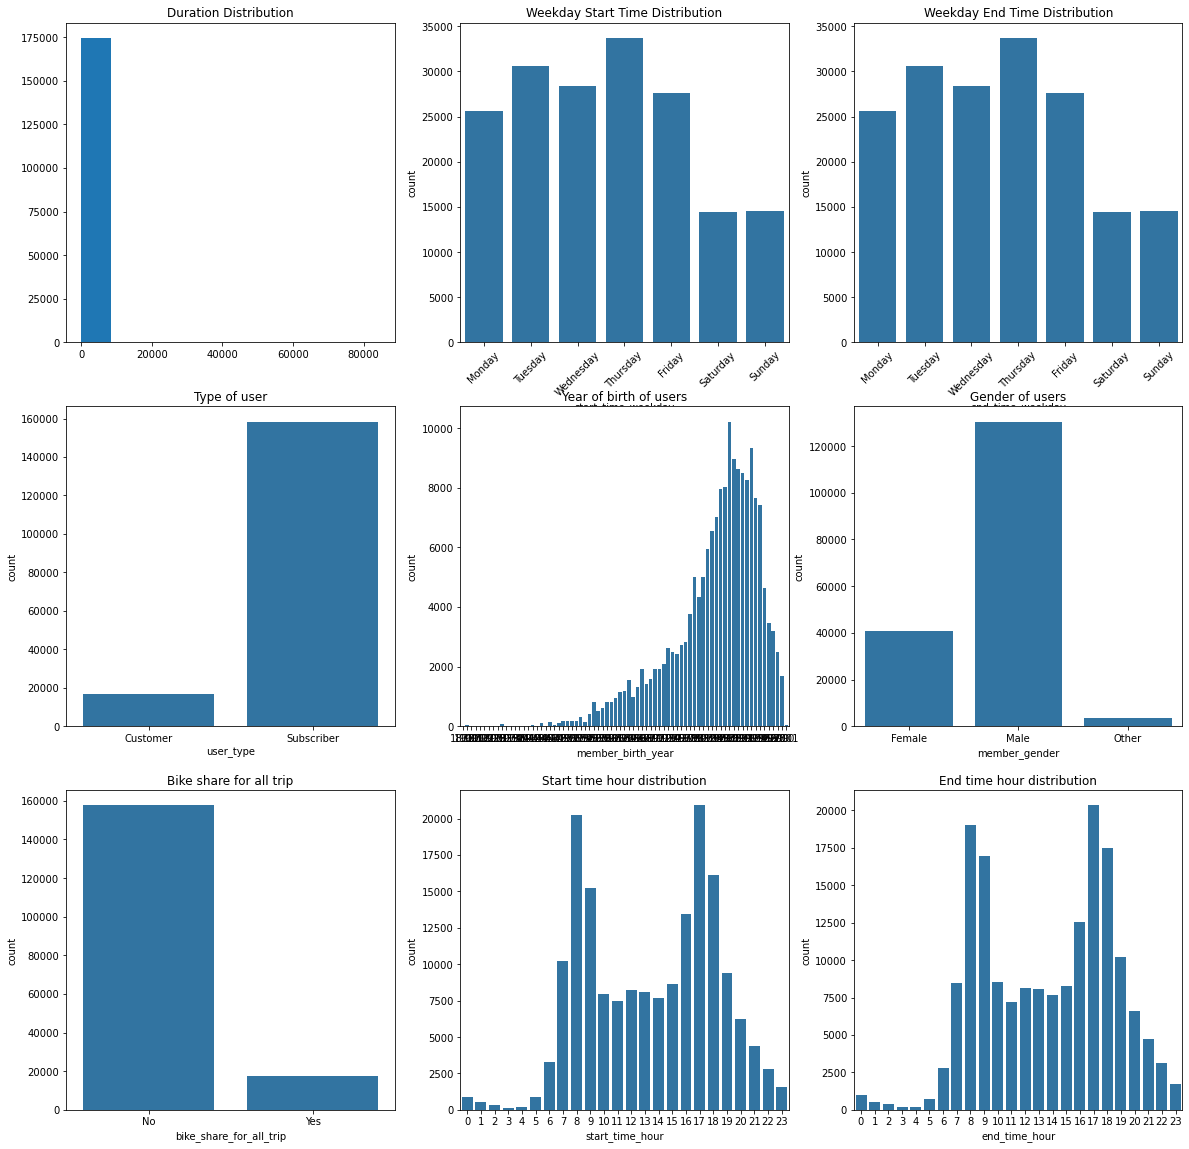

In [9]:
plt.figure(figsize=[20,20])

#Duration plot
plt.subplot(3,3,1)
plt.hist(ford_clean["duration_sec"])
plt.title("Duration Distribution");

#Weekday start plot
plt.subplot(3,3,2)
sb.countplot(data=ford_clean, x="start_time_weekday", order=week_order, color=base_color)
plt.xticks(rotation=45)
plt.title("Weekday Start Time Distribution");

#Weekday end plot
plt.subplot(3,3,3)
sb.countplot(data=ford_clean, x="end_time_weekday", order=week_order, color=base_color)
plt.xticks(rotation=45)
plt.title("Weekday End Time Distribution");

#User type plot
plt.subplot(3,3,4)
sb.countplot(data=ford_clean, x="user_type", color=base_color)
plt.title("Type of user");

#Year of birth plot
plt.subplot(3,3,5)
sb.countplot(data=ford_clean, x="member_birth_year", color=base_color)
plt.title("Year of birth of users");

#Gender of member plot
plt.subplot(3,3,6)
sb.countplot(data=ford_clean, x="member_gender", color=base_color)
plt.title("Gender of users");

#Bike sharing plot
plt.subplot(3,3,7)
sb.countplot(data=ford_clean, x="bike_share_for_all_trip", color=base_color)
plt.title("Bike share for all trip");

#Busiest hours distribution
plt.subplot(3,3,8)
sb.countplot(data=ford_clean, x="start_time_hour", color=base_color)
plt.title("Start time hour distribution");

#Busiest hours distribution
plt.subplot(3,3,9)
sb.countplot(data=ford_clean, x="end_time_hour", color=base_color)
plt.title("End time hour distribution");


After plotting all interesting variables together, two of them need to be reploted: the distribution for duration and the year of birth of users.

Starting with the **distribution duration**. As we can see below, the chart does not give any visual advantage of the variable:

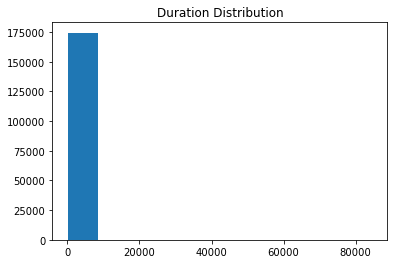

In [10]:
plt.hist(ford_clean["duration_sec"])
plt.title("Duration Distribution");

To make it more visual, a smaller binsize of 60 seconds (1 minute) has been ploted. Because, there are some values around 80000 seconds that make the visualization not good, a limit to 3600 seconds (1 hour) should be enough to start noticing some differences.

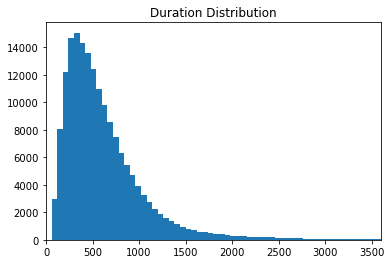

In [11]:
binsize = 60
bins = np.arange(0, ford_clean["duration_sec"].max(), binsize)

plt.hist(ford_clean["duration_sec"], bins=bins)
plt.title("Duration Distribution")
plt.xlim([0,3600]);

In [12]:
ford_clean = ford_clean[ford_clean["duration_sec"] <= 3600]

Now we can clearly draw some conclussions from the histogram like the median time people rent the bike: around 500 seconds (8.5 minutes). All observations with values above 3600 seconds were  dropped to ensure the consistency of the analysis.

Following with the **year of birth of users**, a modification is needed as well because we cannot draw any conclusion. All the missing values were filled with a 0 and the plot shows it:

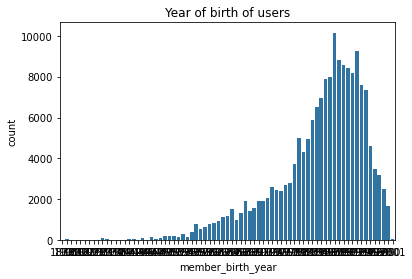

In [13]:
sb.countplot(data=ford_clean, x="member_birth_year", color=base_color)
plt.title("Year of birth of users");

Lets remove the zeros, make the figure size bigger and rotate the x label to understand the chart better.

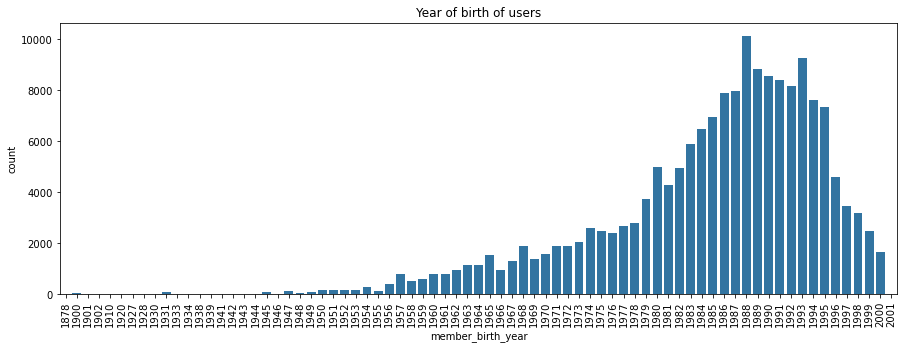

In [14]:
plt.figure(figsize=(15,5))
sb.countplot(data=ford_clean, x="member_birth_year", color=base_color)
plt.xticks(rotation=90)
plt.title("Year of birth of users");

In this case, we can clearly see that the most amount of people have been boorn between 1975 and 2000. Lets zoom in to find out and plot it on a countplot to dont mess with the ticks.

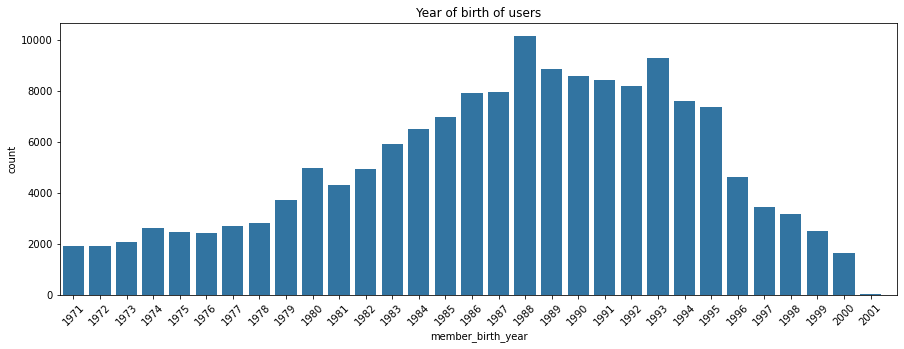

In [15]:
plt.figure(figsize=(15,5))
sb.countplot(data=ford_clean, x="member_birth_year", color=base_color)
plt.xticks(rotation=45)
plt.xlim(43.5,75)
plt.title("Year of birth of users");

Now, it is clearly visible that the most common year of birth between users of the platform is 1988 followed by 1993. To perform further analysis, I will group the years of birth by decades in a new column.

In [19]:
#ford_clean["member_birth_year"] = ford_clean["member_birth_year"].astype(int)
ford_clean["member_birth_decade"] = (ford_clean.member_birth_year.astype(int)//10*10)

The new plot:

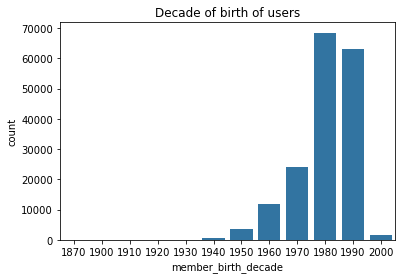

In [26]:
plt.title("Decade of birth of users");
sb.countplot(data=ford_clean, x="member_birth_decade", color=base_color);

This new plot also shows that some data within the dataset is probably impossible. Users born in the 1870s would be 150 years old now!! This is not plausible so we will drop all the values from people born before 1940.

_Note: people born in the 1930's can still use the bike. However, the representation is the dataset is insignificance for the anlaysis and can make bivariate and multivariate exploration harder_

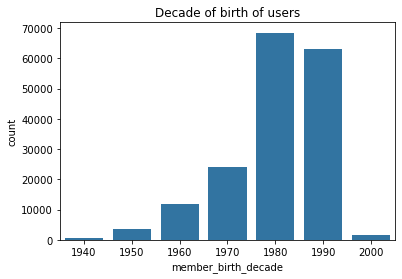

In [31]:
#Transformation
ford_clean = ford_clean[ford_clean["member_birth_year"].astype(int) >= 1940]

#Plot to test
plt.title("Decade of birth of users");
sb.countplot(data=ford_clean, x="member_birth_decade", color=base_color);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

In the **duration distribution**, a few anomalies were discovered. Some values were around 80,000 seconds which seems fairly unusual to rent a bike. They are probably misscalulations.

In the **year of birth distribution**, the chart was not clear. Some values were also missintroduced. It is impossible for people born in the 1870s to ride a bike in 2019.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

For the first problem, all the values above 3600 were dropped. The significance on the whole dataset is minimum as the frequency is so low. This way, we can assure more consistency in our data.

For the second problem, all users with decades of birth older than 1940's were dropped.

## Bivariate Exploration

First, lets explore the cuantitave variable with the categorical variables. This provides useful information regarding user habits and how duration depends on other variables.

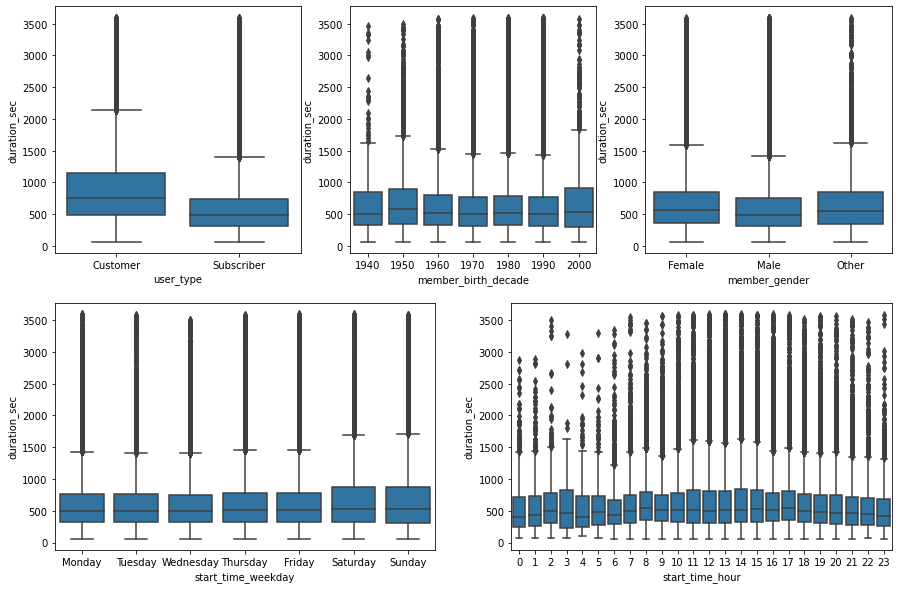

In [84]:
#Set figure size
plt.figure(figsize=(15,10))

#Duration per user 
plt.subplot(2, 3, 1)
sb.boxplot(data=ford_clean, x="user_type", y="duration_sec", color=base_color);

#Duration per decade of birth
plt.subplot(2, 3, 2)
sb.boxplot(data=ford_clean, x="member_birth_decade", y="duration_sec", color=base_color);

#Duration per gender
plt.subplot(2, 3, 3)
sb.boxplot(data=ford_clean, x="member_gender", y="duration_sec", color=base_color);

#Duration per start hour
plt.subplot(2, 2, 4)
sb.boxplot(data=ford_clean, x="start_time_hour", y="duration_sec", color=base_color);

#Duration per start weekday
plt.subplot(2, 2, 3)
sb.boxplot(data=ford_clean, x="start_time_weekday", y="duration_sec", color=base_color, order=week_order);

Now, lets explore categorical variables:

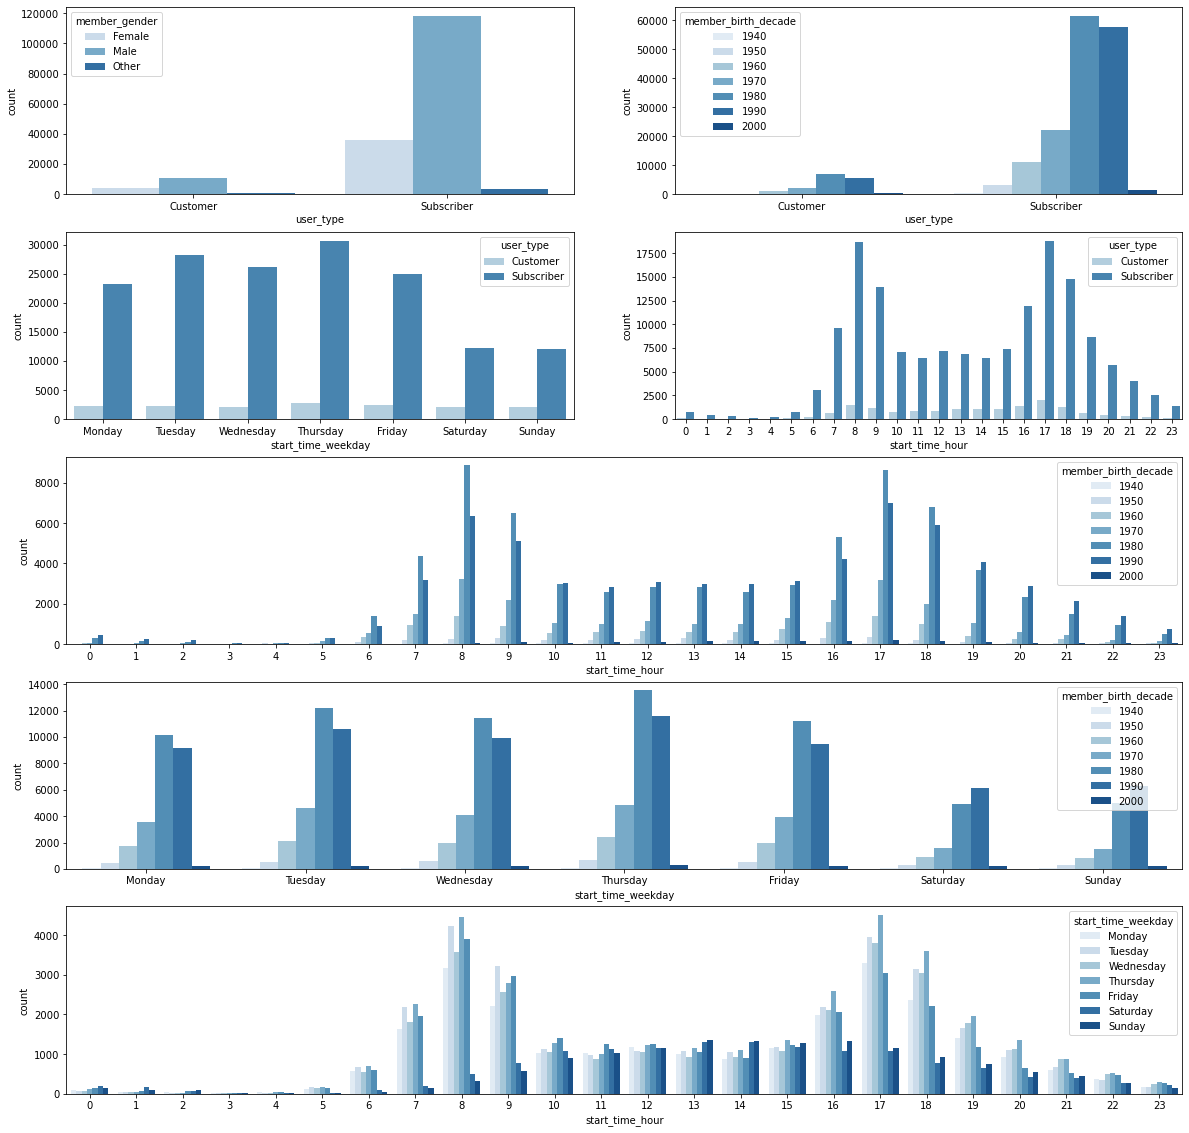

In [118]:
plt.figure(figsize=[20,20])

#User type by gender
plt.subplot(5,2,1)
sb.countplot(data=ford_clean, x="user_type", hue="member_gender", palette="Blues");

#User type by decade of birth
plt.subplot(5,2,2)
sb.countplot(data=ford_clean, x="user_type", hue="member_birth_decade", palette="Blues");

#User type by weekday
plt.subplot(5,2,3)
sb.countplot(data=ford_clean, x="start_time_weekday", hue="user_type", palette="Blues", order=week_order);

#User type by houe
plt.subplot(5,2,4)
sb.countplot(data=ford_clean, x="start_time_hour", hue="user_type", palette="Blues");

#Hour by decade of birth
plt.subplot(5,1,3)
sb.countplot(data=ford_clean, x="start_time_hour", hue="member_birth_decade", palette="Blues");

#Day by decade of birth
plt.subplot(5,1,4)
sb.countplot(data=ford_clean, x="start_time_weekday", hue="member_birth_decade", palette="Blues", order=week_order);

#Hour by startday
plt.subplot(5,1,5)
sb.countplot(data=ford_clean, x="start_time_hour", hue="start_time_weekday", palette="Blues", hue_order=week_order);



### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

A lot of useful data was gathered from this plotting:
- Customers tend to use the bike more time than suscribers. This may be related with the usage. Subscribers might use the bike to commute everyday and prefer to pay a subscription rather than paying on the go.
- Females rent the bike for longer time than males. Again, this might be related with the usage.
- On weekends, users rent the bike for longer time. This may be explained by the different usage: probably leisure activities.
- At 8 and 17, the bike is rented for longer. This may be related to the work schedule. People entering their jobs or leaving.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

When plotting all the categorical values, few interesting obervations could be observed:
- The proportion of male suscribers is higher than female suscribers. On the other other hand, the proportion of male customers is not as high as female customers.
- The number of bike rides on Saturdays and Sundays is lower, we knew that. However, the proportion of non-suscriber users who rent the bike these days of the week is higher. In other words, less subscribers take the bike these days but the same amount of customers take it. This might have to do with leisure activites. Casual users taking the bike only on weekends while hardcore users taking the bike to commute only on weekdays.
- Very few people take the bike early in the morning during weekends. Also, during late night hours, more people rent the bike duyring weekends. This is probably related to people not having to wake early during weekends.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!